# Level 2: Rice Crop Yield Forecasting Tool Notebook by Israel Orere

## Challenge Level 2 Overview

<p align="justify"> The goal of the Level 2 challenge is to predict the yield of rice crop at a given location using satellite data. Other data sources may be used to augment the satellite data but these sources must be open to the public and duly identified.
</p>

<b>Data used for this approach: </b><p align="justify"> <p>

<p align="justify">For this approach, VV and VH bands from the Setinel-1-RTC dataset on Microsoft's planetary computer were used to build the model. Statistical features were drawn from these bands and band interaction features were also incorporated into the model.</p>
    


## Load In Dependencies

To run this notebook, some important dependencies have to be present

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.metrics import r2_score


# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

## Reduce memory function

This function converts data types in order to reduce memory usage

In [2]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')
        
        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)  
        
    return df

## Response Variable

Before building the model, we need to load in the rice crop yield data. In particular, rice crop yield data was collected for the period of late-2021 to mid-2022 over the Chau Phu, Chau Thanh and Thoai Son districts.

This is a dense rice crop region with a mix of double and triple cropping cycles. Every data point has to be matched with its corresponding crop cycle.
The crop cycles are Winter-Spring ( November – April) and the Summer-Autumn (April – August). E.g., the harvest date for the first entry is 15th July 2022. The corresponding crop cycle will be Summer-Autumn (April – August). 

The data consists of geo locations (Latitude and Longitude), District, Season, Rice Crop Intensity, Date of Harvest, Field Size (in Hectares) with the yield in each geo location.

### Load the crop_yield_data via a relative path in residing in the notebook's directory.

In [3]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv")
# display the first few entries in the crop_yield_data
crop_yield_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


## Prepare test file for concatentaion with the crop_yield_data which holds the training data

First, the test file which contains the geo-coordinates for the test fields is loaded via another relative path from the directory where this notebook resides.

The target column, 'Rice yield (Kg/ha)' is defined and filled with a dummy 'test' string to distinguish train from test fields. 

This column is then dropped because it isn't needed to get the VV and VH band values.

The 'Field size (ha)' column is renamed to match the training set's corresponding column name. 

The 'ID No' field is also dropped as it isn't present in the training data.



In [4]:
test_file = pd.read_csv('Challenge_2_submission_template.csv')
test_file['Rice Yield (kg/ha)']='test'
test_file.drop(['Predicted Rice Yield (kg/ha)'], axis=1, inplace=True)
test_file['Field size (ha)']=test_file['Field size (ha)']
test_file.drop(['ID No'], axis=1, inplace=True)

### Another data frame is created from the concatenation of the train and test data. This will ensure that both datasets can have their band values generated in one shot.

In [5]:
original_data=pd.concat([crop_yield_data, test_file])

#### Check for null values

In [6]:
original_data.isnull().sum()

District                                          0
Latitude                                          0
Longitude                                         0
Season(SA = Summer Autumn, WS = Winter Spring)    0
Rice Crop Intensity(D=Double, T=Triple)           0
Date of Harvest                                   0
Field size (ha)                                   0
Rice Yield (kg/ha)                                0
dtype: int64

#### confirm that the target column for the test fields have been properly filled

In [7]:
test_file['Rice Yield (kg/ha)']

0     test
1     test
2     test
3     test
4     test
      ... 
95    test
96    test
97    test
98    test
99    test
Name: Rice Yield (kg/ha), Length: 100, dtype: object

### Get a sense of the distribution of the target values

In [8]:
crop_yield_data['Rice Yield (kg/ha)'].value_counts()

7200    91
6000    78
6400    67
5500    59
8000    55
5600    47
6500    26
6800    25
7000    21
7600    20
7040    16
6640     9
7760     8
6600     7
7500     5
6880     3
6960     3
7920     3
5200     3
7840     2
7400     2
6240     1
6160     1
5440     1
7900     1
6520     1
7440     1
6700     1
Name: Rice Yield (kg/ha), dtype: int64

## Quality reports for the columns in the crop yield (train) dataset to provide information on the column's distribution and its statistics

In [9]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, 
    unique numbers, datatypes etc.
    
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total NaN', 'Percent of NaN','Nunique', 'Dtype'])
    display(quality_df)


def object_count_plot(df):
    """
    Description : Plot countplot for all categorical features 
    present in the dataframe passed
    
    Argument : Dataframe
    """
    
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            plt.savefig(f'{var} distribution plot.png')
            
def numeric_distribution_plot(df):
    """
    Description : Gives distribution plot for all the numeric features
    in the dataframe passed
    
    Argument : Dataframe
    """
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna())
            plt.tight_layout()
            plt.show()
            if col == 'Rice Yield (kg/ha)':
                plt.savefig('Rice yield distribution plot.png')
                continue
            plt.savefig(f'{col} distribution plot.png')

count    557.000000
mean      10.418423
std        0.107198
min       10.195117
25%       10.334417
50%       10.412537
75%       10.494104
max       10.676956
Name: Latitude, dtype: float64


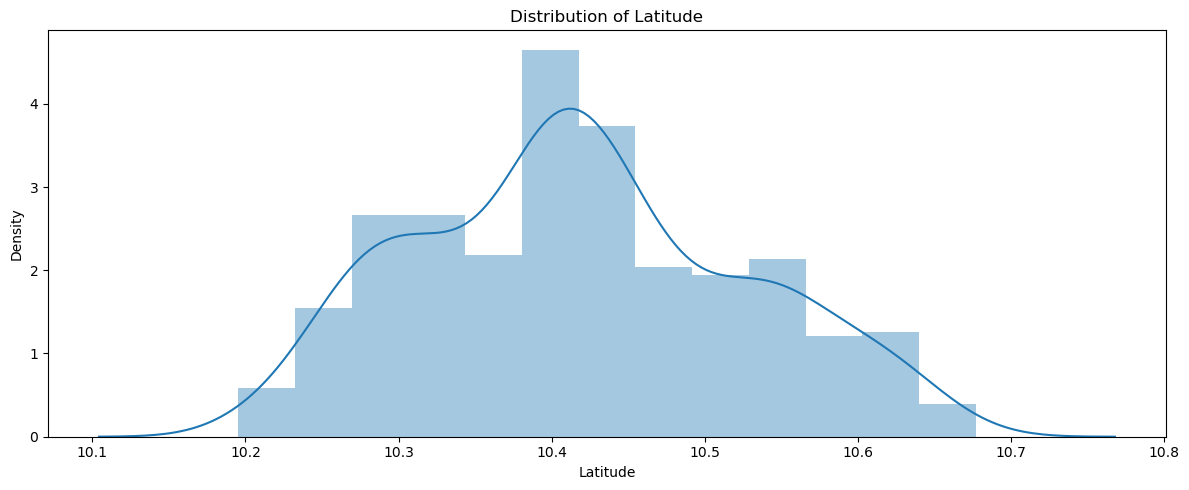

count    557.000000
mean     105.221984
std        0.078292
min      105.075243
25%      105.160660
50%      105.208993
75%      105.275589
max      105.424059
Name: Longitude, dtype: float64


<Figure size 640x480 with 0 Axes>

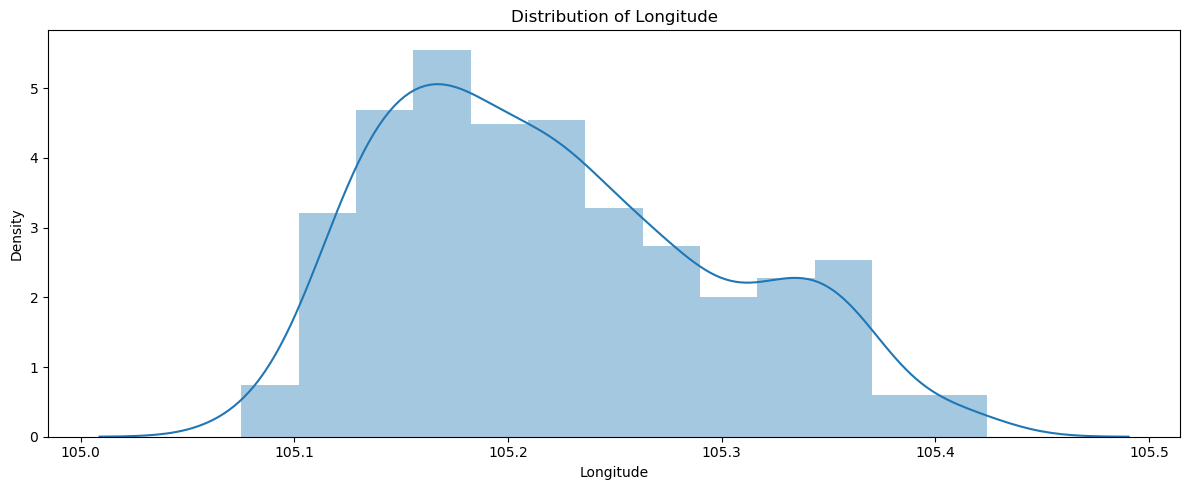

count    557.000000
mean       2.666732
std        1.246411
min        1.200000
25%        1.800000
50%        2.200000
75%        3.200000
max        9.000000
Name: Field size (ha), dtype: float64


<Figure size 640x480 with 0 Axes>

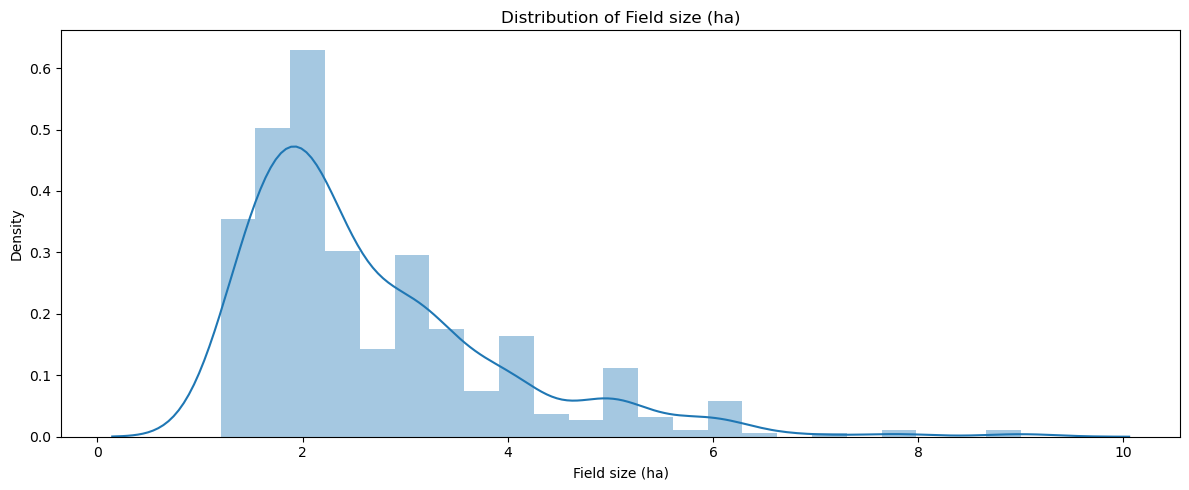

count     557.000000
mean     6631.310592
std       795.533782
min      5200.000000
25%      6000.000000
50%      6500.000000
75%      7200.000000
max      8000.000000
Name: Rice Yield (kg/ha), dtype: float64


<Figure size 640x480 with 0 Axes>

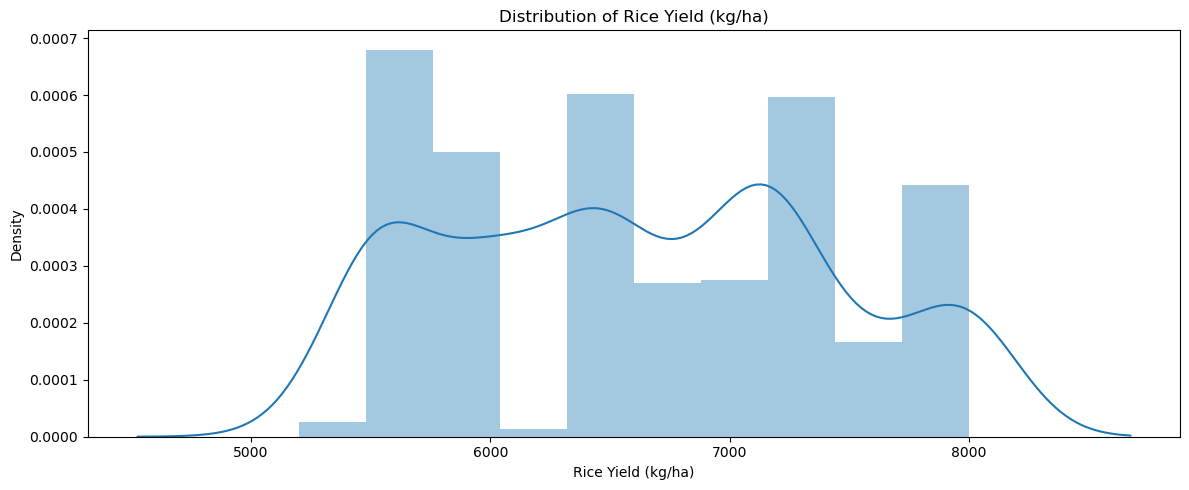

<Figure size 640x480 with 0 Axes>

In [10]:
numeric_distribution_plot(crop_yield_data)

Chau_Thanh    218
Thoai_Son     171
Chau_Phu      168
Name: District, dtype: int64


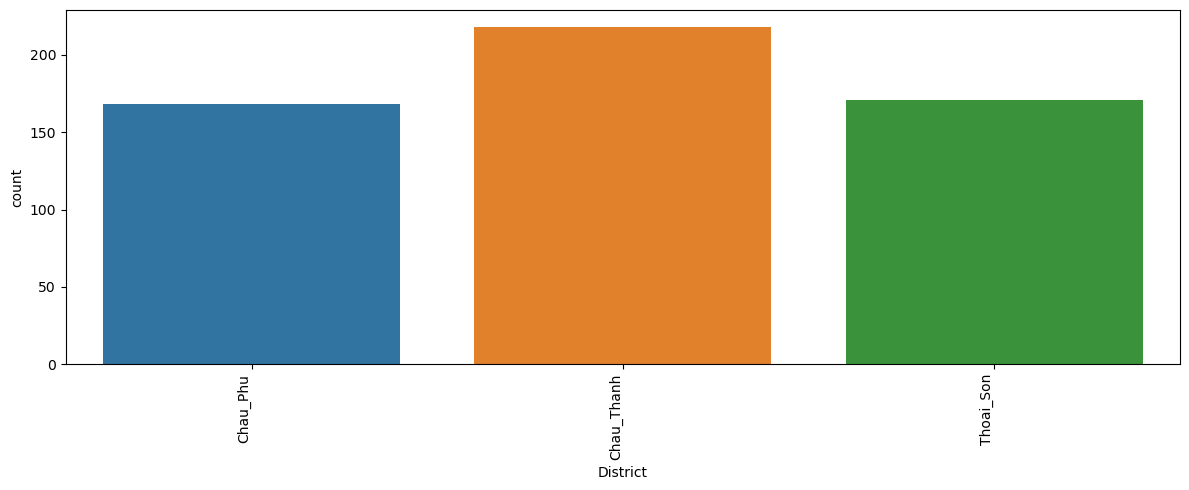

WS    300
SA    257
Name: Season(SA = Summer Autumn, WS = Winter Spring), dtype: int64


<Figure size 640x480 with 0 Axes>

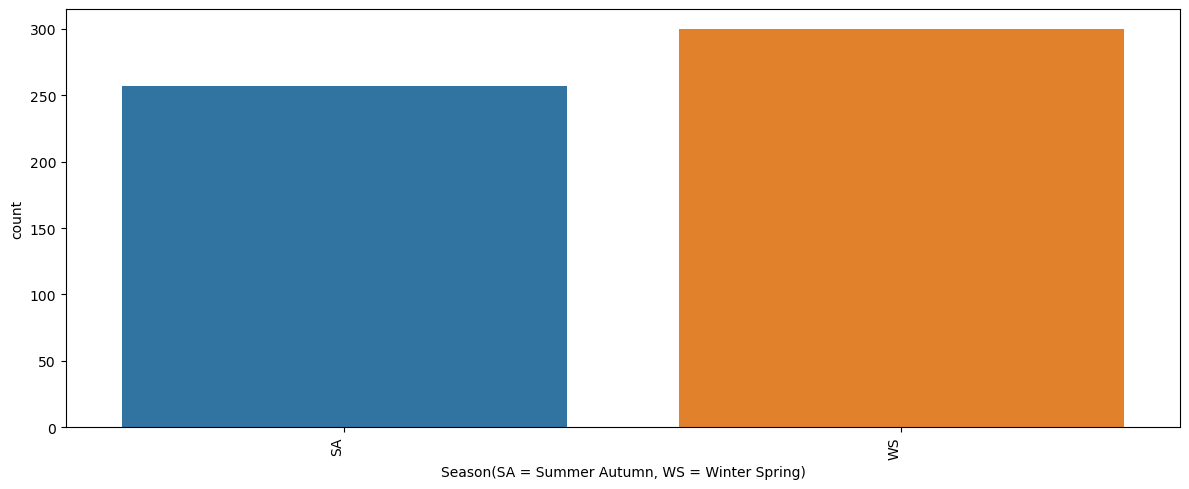

T    470
D     87
Name: Rice Crop Intensity(D=Double, T=Triple), dtype: int64


<Figure size 640x480 with 0 Axes>

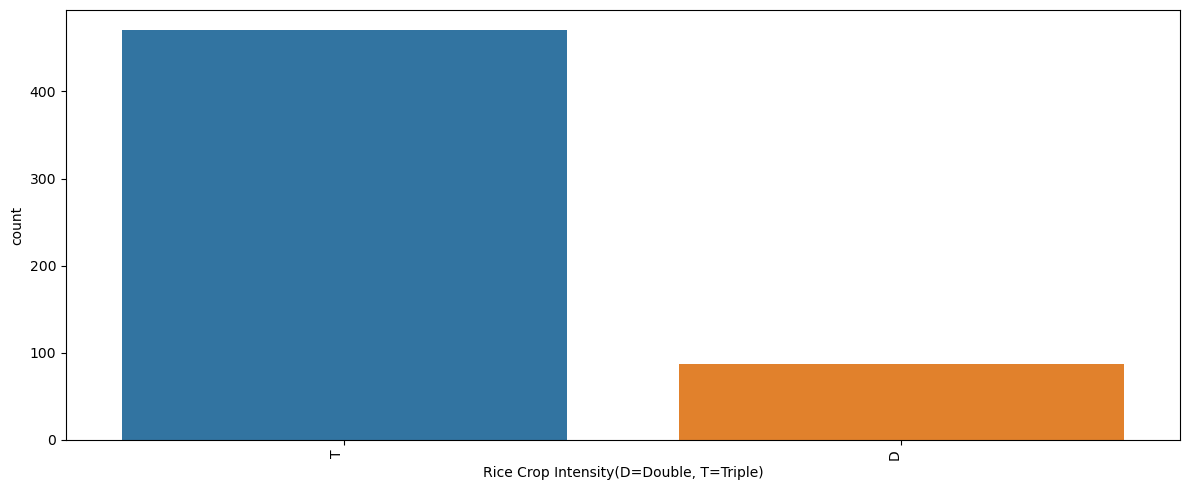

10-04-2022    80
20-07-2022    56
27-03-2022    40
15-07-2022    27
28-07-2022    27
05-08-2022    25
12-04-2022    23
25-03-2022    21
26-07-2022    18
14-07-2022    18
26-03-2022    17
22-04-2022    15
12-07-2022    14
01-04-2022    13
22-03-2022    11
23-07-2022    11
24-03-2022    11
20-03-2022    10
03-04-2022    10
19-07-2022     9
20-04-2022     9
13-04-2022     8
09-08-2022     8
17-07-2022     7
22-07-2022     7
10-07-2022     7
28-03-2022     6
05-04-2022     6
04-08-2022     6
25-07-2022     6
05-07-2022     5
16-04-2022     5
18-03-2022     5
21-07-2022     4
06-04-2022     3
04-04-2022     2
13-07-2022     2
09-04-2022     2
02-04-2022     1
07-04-2022     1
21-03-2022     1
Name: Date of Harvest, dtype: int64


<Figure size 640x480 with 0 Axes>

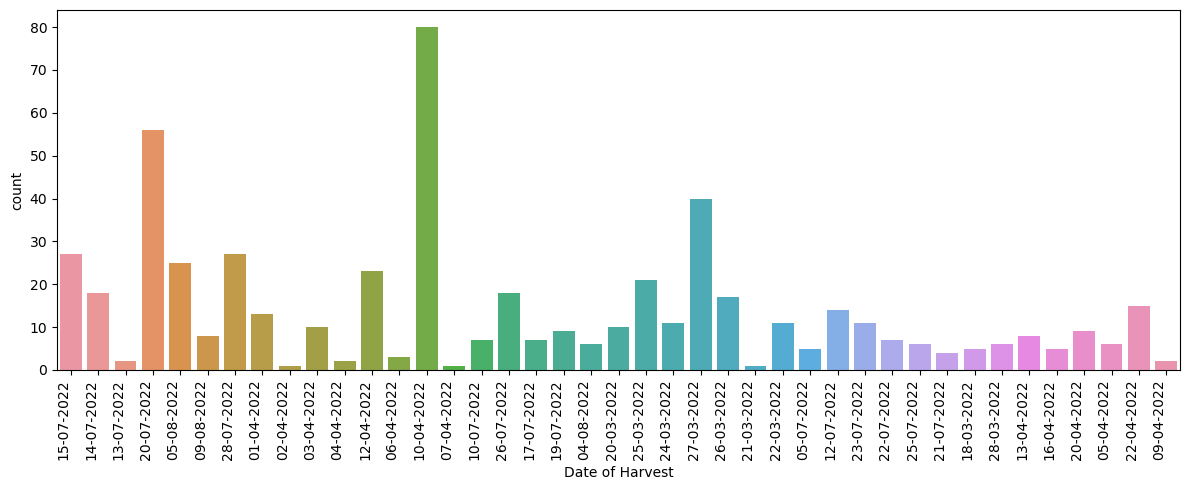

<Figure size 640x480 with 0 Axes>

In [11]:
object_count_plot(crop_yield_data)

## Crop yields are usually higher in the Winter spring season. Will the model be able to capture this information without the season variable?

In [12]:
crop_yield_data.groupby('Season(SA = Summer Autumn, WS = Winter Spring)')['Rice Yield (kg/ha)'].mean()

Season(SA = Summer Autumn, WS = Winter Spring)
SA    5926.692607
WS    7234.933333
Name: Rice Yield (kg/ha), dtype: float64

## Predictor Variables

<p align ="justify">Now that we have our crop yield data, it is time to gather and generate the predictor variables from the Sentinel-1 dataset.

   

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Here we are generating timeseries band values over a period of four months.</p>


<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
       
</ul>

    


### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV, VH band values, VV/VH and RVI values for a particular location over the specified time window. I have fetched data from the beginning of the planting season till the date of harvest.</p>

In [13]:
def get_sentinel_data(longitude, latitude, season, Date_of_Harvest, assests):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    #format Date of Harvest string to match that of %%YYYY-MM-DD
    split=Date_of_Harvest.split('-')
    split[0], split[-1] = split[-1], split[0]
    Date_of_Harvest='-'.join(split)
    bands_of_interest = assests
    if season == 'SA':
        time_slice = f"2022-04-01/{Date_of_Harvest}"
    if season == 'WS':
        time_slice = f"2021-11-01/{Date_of_Harvest}"
    
    #Define a 5*5 bounding box aroud a given latitude, Longitude coordinate as a measure to reduce speckle
    box_size_deg = 0.0004
    min_lon = longitude-box_size_deg/2
    min_lat = latitude-box_size_deg/2
    max_lon = longitude+box_size_deg/2
    max_lat = latitude+box_size_deg/2
    bounds = [min_lon, min_lat, max_lon, max_lat]
        
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    RVI_list=[]
    
    bbox_of_interest = bounds
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)

    items = list(search.get_all_items())

    item = items[0]
    items.reverse()
   

    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/(np.median(vh)))
            dop = (np.median(vv) / (np.median(vv) + np.median(vh)))
            m = 1 - dop
            rvi = (np.sqrt(m))*((4*np.median(vh))/(np.median(vv) + np.median(vh)))
            RVI_list.append(rvi)
           

              
    return vv_list, vh_list, vv_by_vh_list, RVI_list

## Get sample images. 5 for each season

This is done to get a general idea of the pixel values for a given band, date and location

In [14]:
exploratory_data_1=original_data.iloc[:5, :]
exploratory_data_2=original_data.iloc[553: 558, :]
exploratory_data=pd.concat([exploratory_data_1, exploratory_data_2])

In [15]:
def get_image_data(longitude, latitude, season, Date_of_Harvest, assests):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    split=Date_of_Harvest.split('-')
    split[0], split[-1] = split[-1], split[0]
    Date_of_Harvest='-'.join(split)
    bands_of_interest = assests
    if season == 'SA':
        time_slice = f"2022-04-01/{Date_of_Harvest}"
    if season == 'WS':
        time_slice = f"2021-11-01/{Date_of_Harvest}"

        
    box_size_deg = 0.0004
    min_lon = longitude-box_size_deg/2
    min_lat = latitude-box_size_deg/2
    max_lon = longitude+box_size_deg/2
    max_lat = latitude+box_size_deg/2
    bounds = [min_lon, min_lat, max_lon, max_lat]
        
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    RVI_list=[]
    time_list=[]
    
    bbox_of_interest = bounds
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)

    items = list(search.get_all_items())

    item = items[0]
    items.reverse()
   

    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(vv)
            vh_list.append(vh)
    return vv_list, vh_list

In [16]:
assests = ['vh','vv']
train_band_values=exploratory_data.progress_apply(lambda x: get_image_data(x['Longitude'], x['Latitude'], x['Season(SA = Summer Autumn, WS = Winter Spring)'], x['Date of Harvest'], assests), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
# vv_by_vh = [x[2] for x in train_band_values]
# rvi=[x[3] for x in train_band_values]
# rvi2=[x[4] for x in train_band_values]
# # vvdpi=[x[4] for x in train_band_values]
# # theta= [x[5] for x in train_band_values]
# purity=[x[4] for x in train_band_values]
# entropy=[x[5] for x in train_band_values]

data_image = pd.DataFrame(list(zip(vh,vv)),columns = ["vv_list","vh_list"])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
##first image in the exploratory data
(data_image.iloc[0, 0])
##From the results, it is clear that the median is a good way to produce a single value to represent the image

### Get Sentinel-1-RTC Data

In [ ]:
# Get Sentinel-1-RTC Data
assests = ['vh','vv']
train_band_values=original_data.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'], x['Season(SA = Summer Autumn, WS = Winter Spring)'], x['Date of Harvest'], assests), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
rvi=[x[3] for x in train_band_values]
# rvi2=[x[4] for x in train_band_values]
# # vvdpi=[x[4] for x in train_band_values]
# # theta= [x[5] for x in train_band_values]
# purity=[x[4] for x in train_band_values]
# entropy=[x[5] for x in train_band_values]

data_setinel1_median = pd.DataFrame(list(zip(vh,vv,vv_by_vh, rvi)),columns = ["vv_list","vh_list","vv/vh_list", 'rvi_list'])

In [ ]:
##save the retieved band data for future reference
data_setinel1_median.to_csv('data_setinel1_mediancsv', index=False)

In [17]:
##read the setinel data
data=pd.read_csv('data_setinel1_mediancsv')

In [18]:
import math
##To make use of some necessary functions, the math module is imported

## Remove Nan Values, if any is present. The function also turns the xarray into a list

In [19]:
def remove_nan(data):
        data=[element for element in eval(data) if not math.isnan(element)]
        return data

In [20]:
for col in data.columns:
    data[col]=data[col].apply(remove_nan)

### Visualize temporal data for each band and band combinations. First for the SA season and then for WS

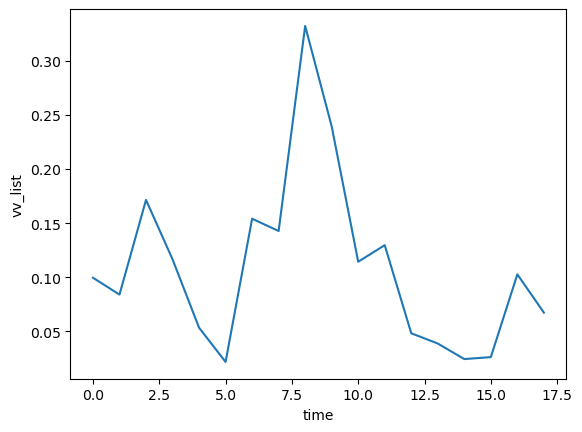

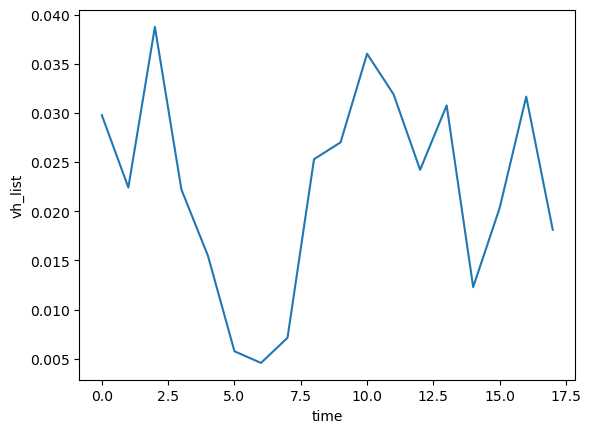

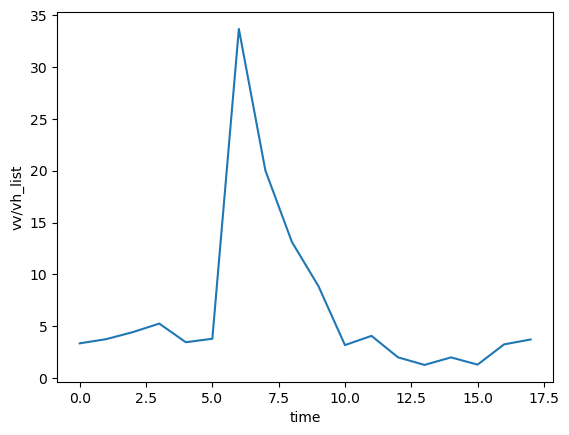

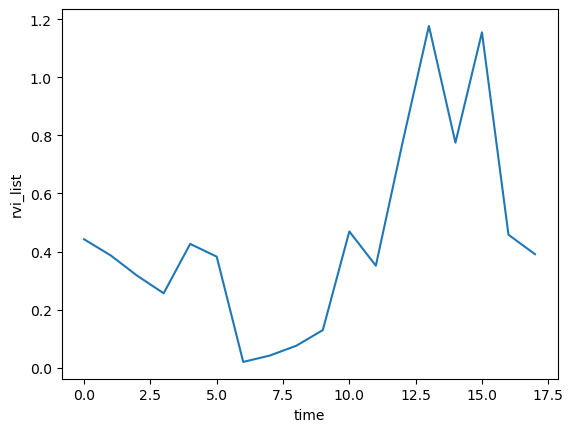

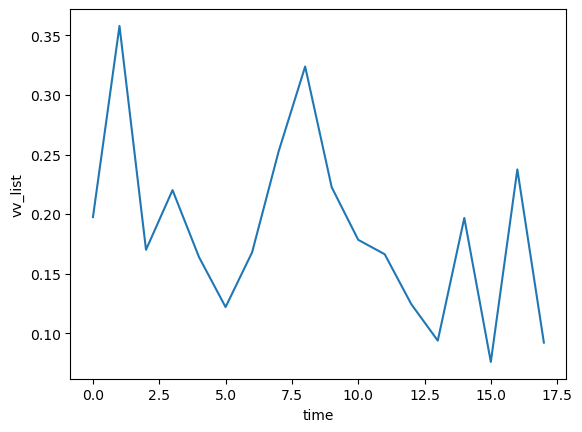

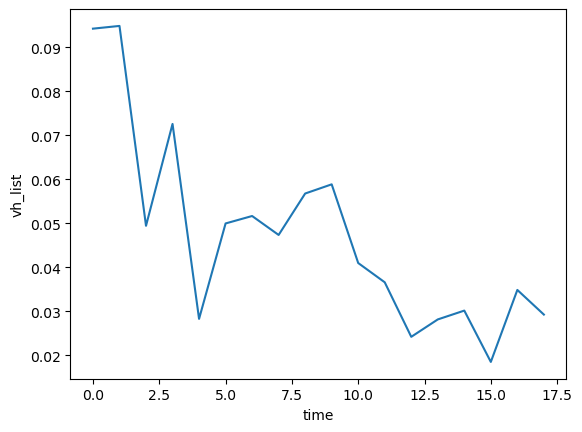

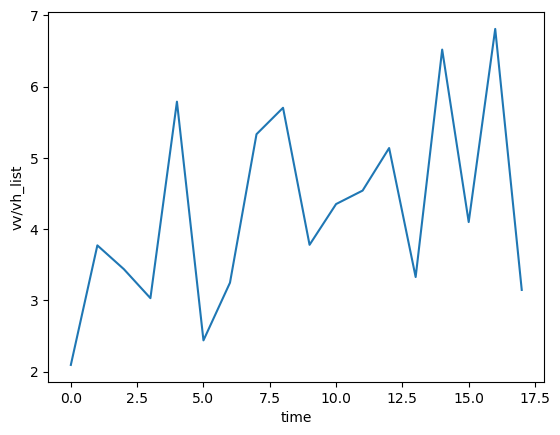

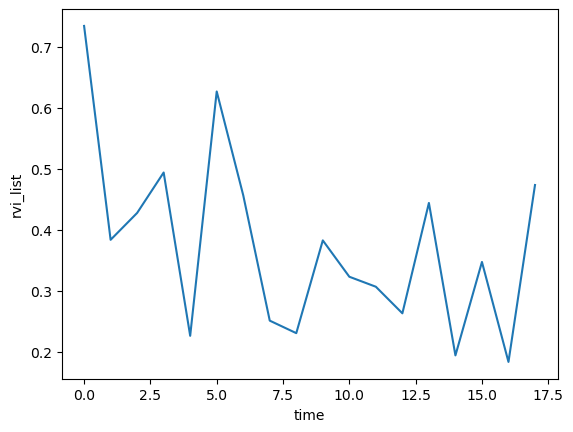

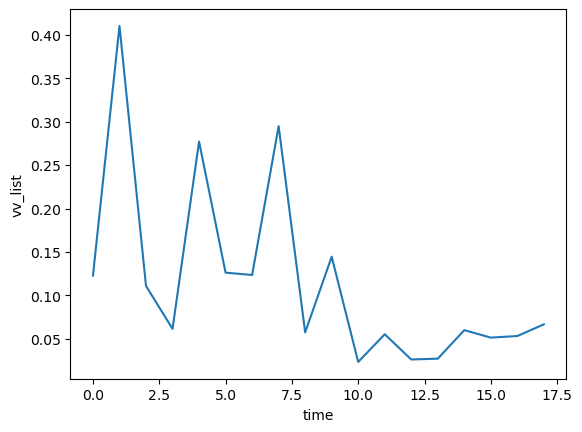

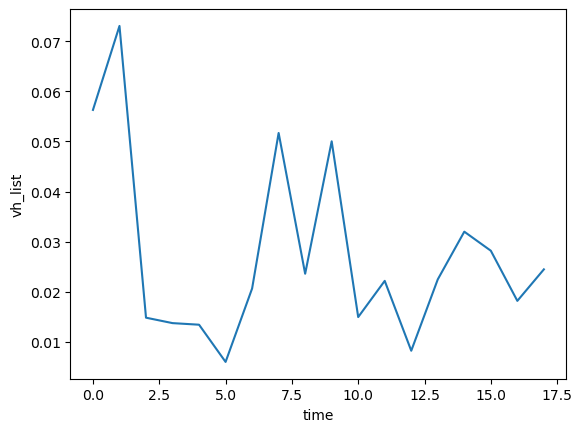

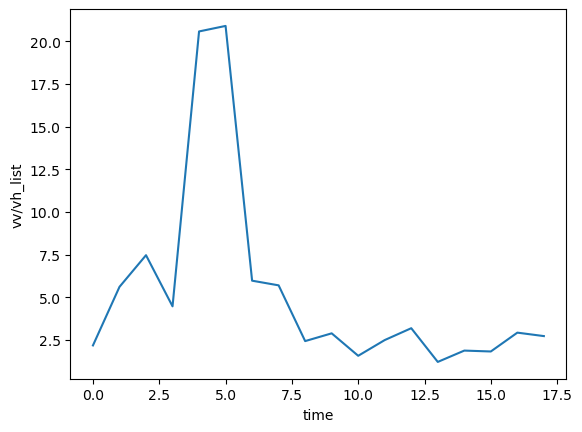

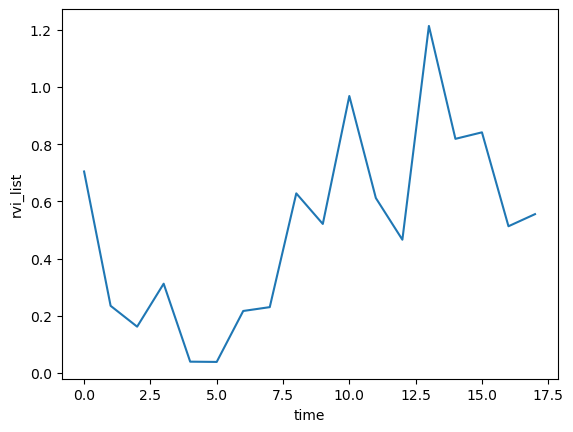

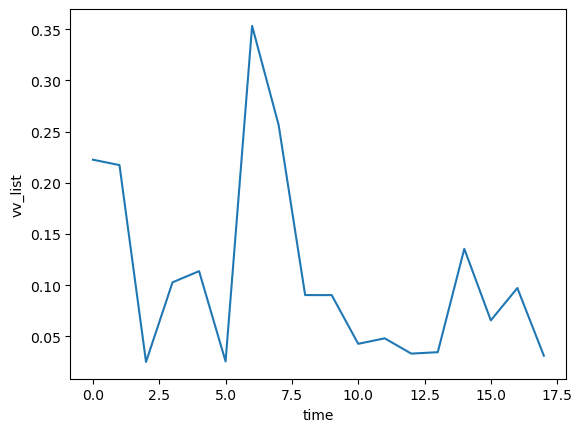

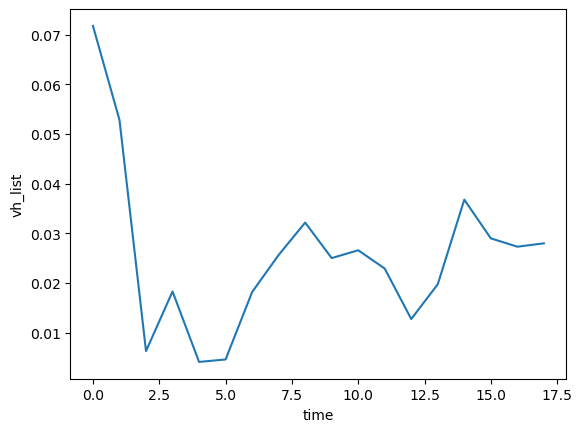

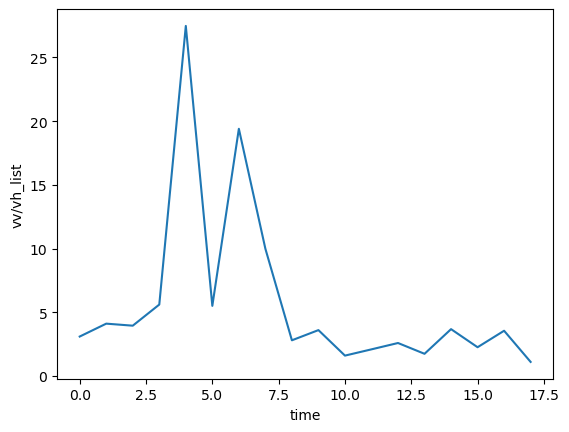

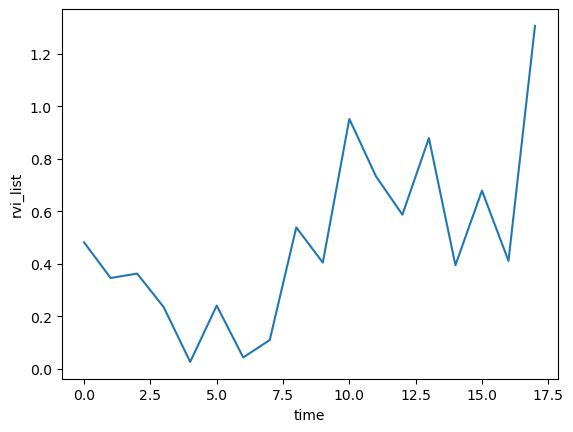

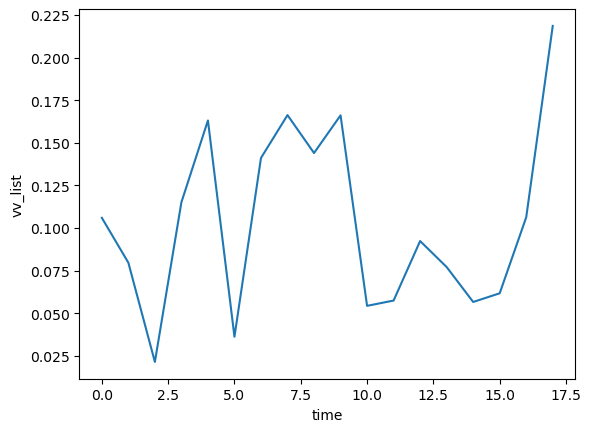

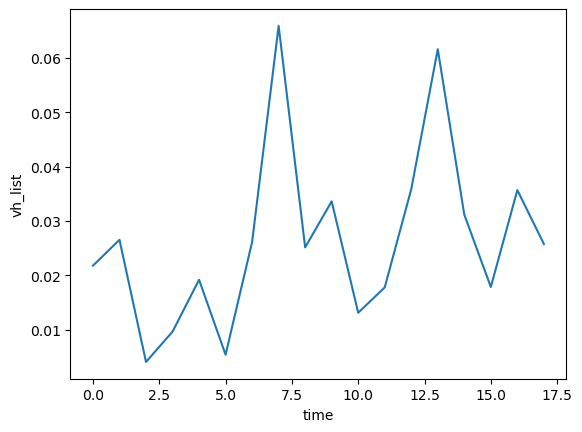

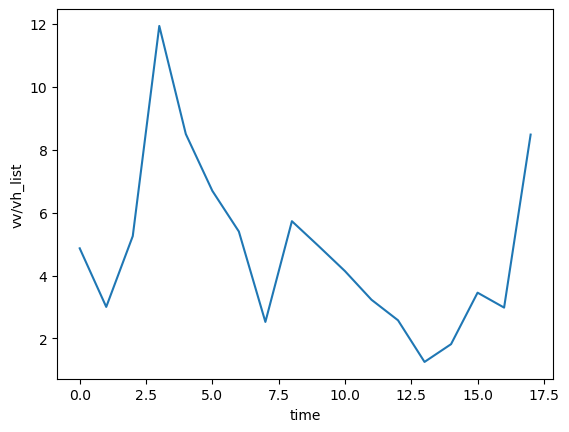

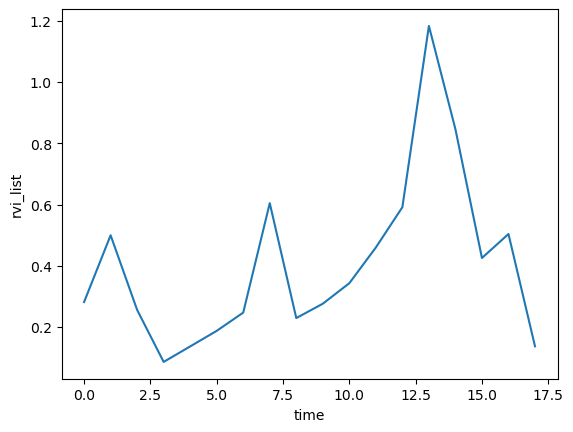

In [21]:

for i in range(5):
    for j in range(4):
        plt.plot(pd.Series(data.iloc[i, j]))
        plt.xlabel("time")
        plt.ylabel(f'{data.columns[j]}')
        if data.columns[j] == 'vv/vh_list':
          plt.savefig(f'vv ratio vh for {i} entry season SA')
          plt.show()
          continue
        plt.savefig(f'{data.columns[j]}  for {i} entry season SA')
        plt.show()
        
        

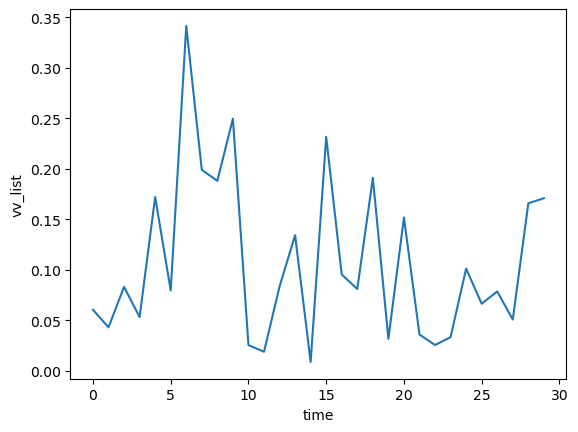

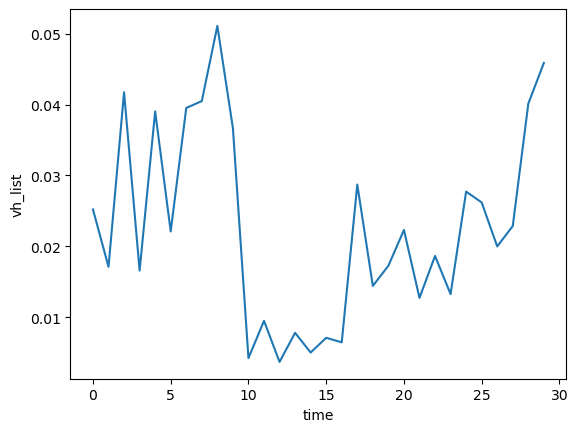

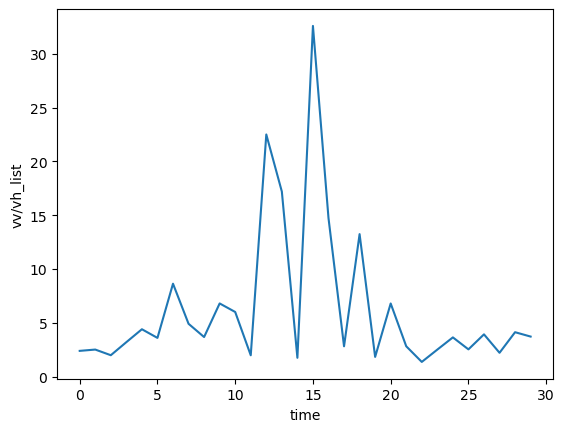

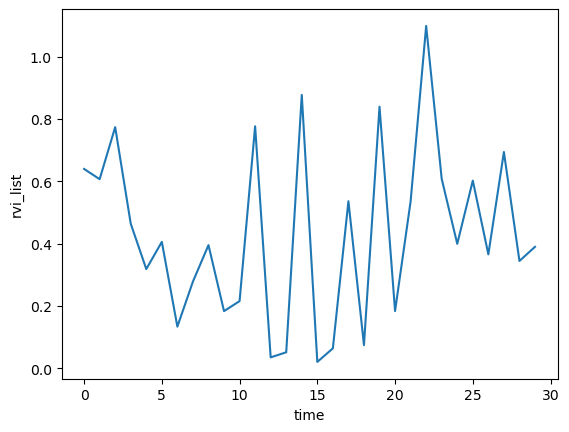

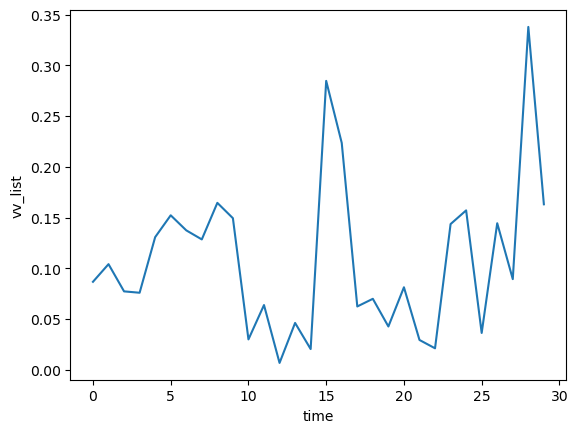

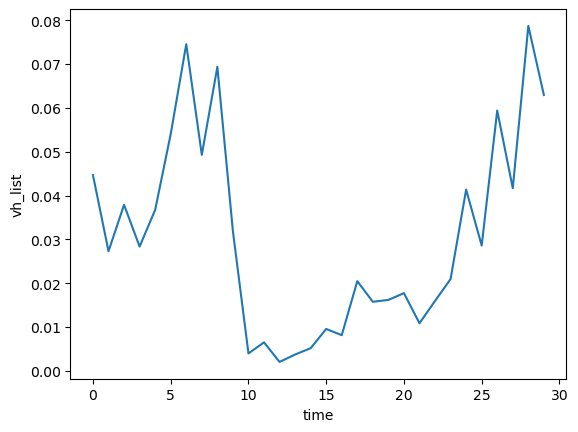

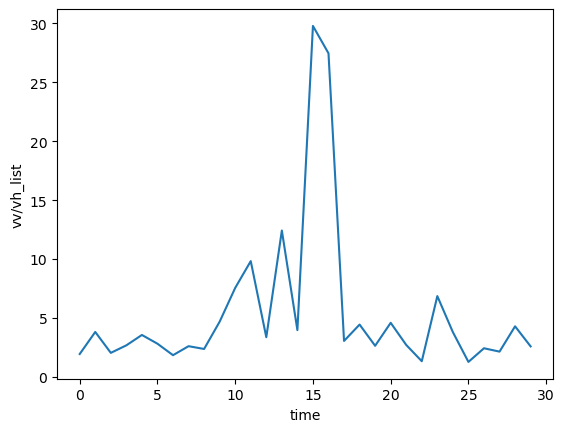

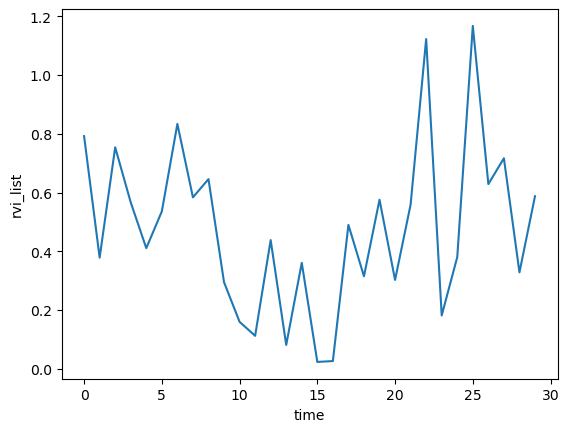

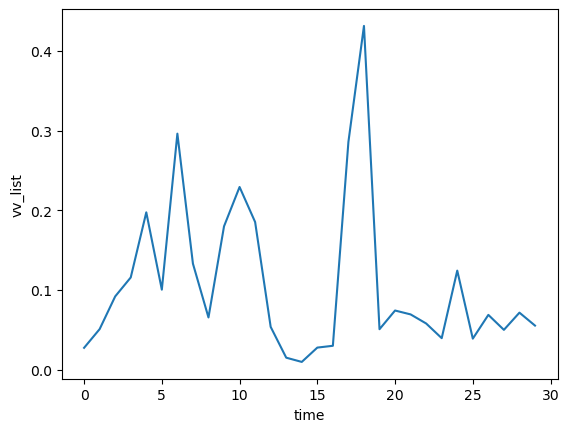

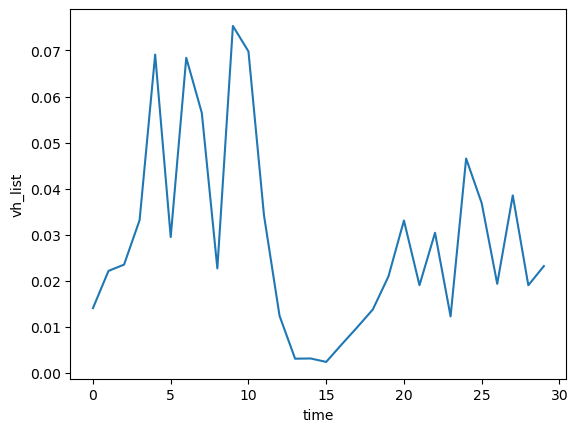

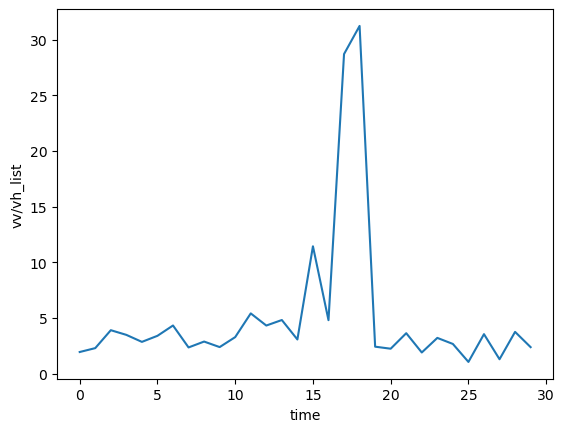

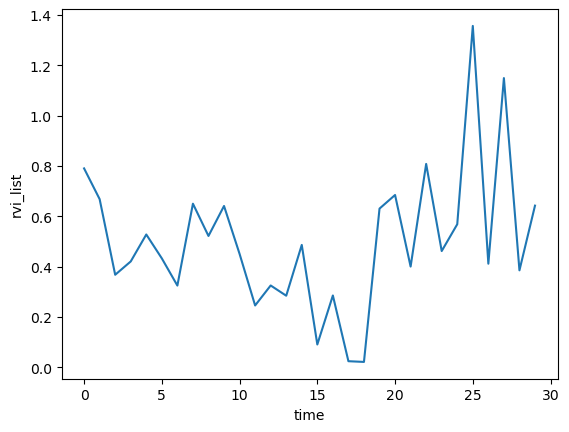

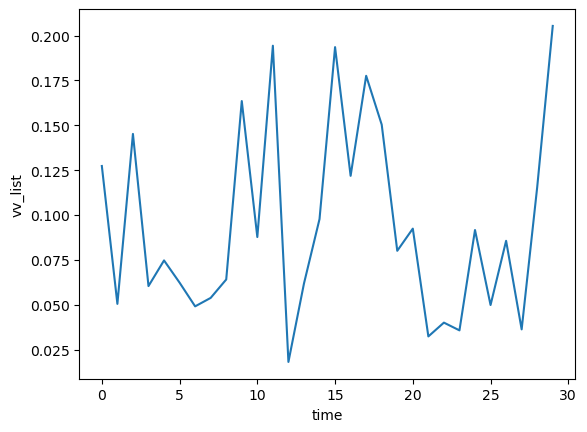

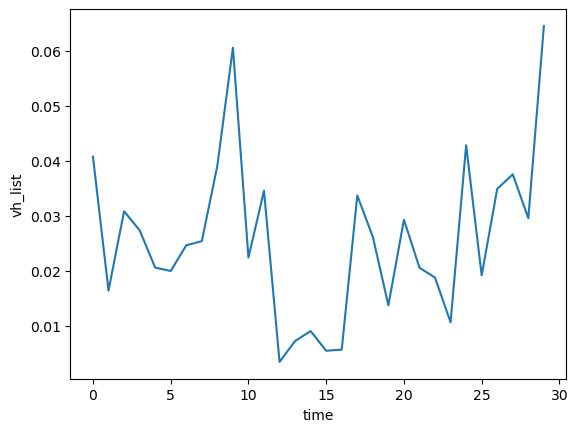

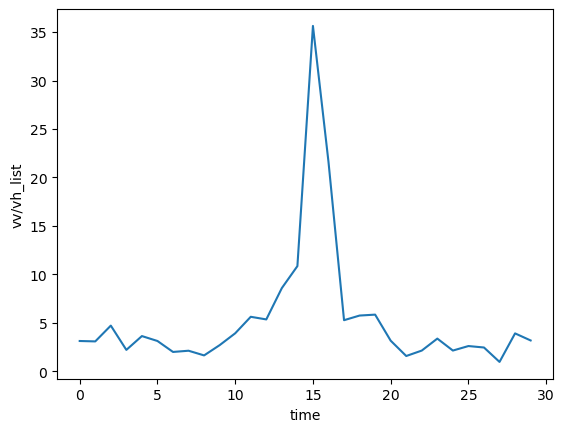

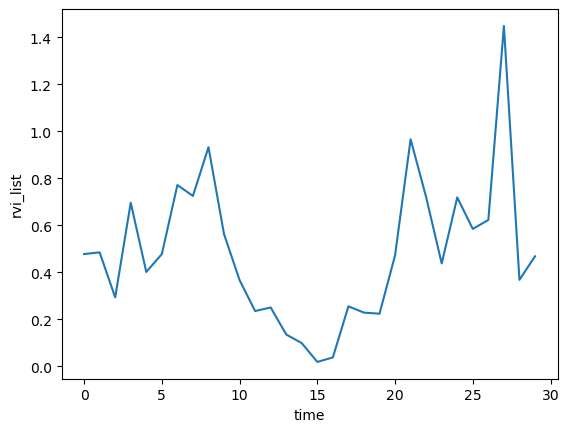

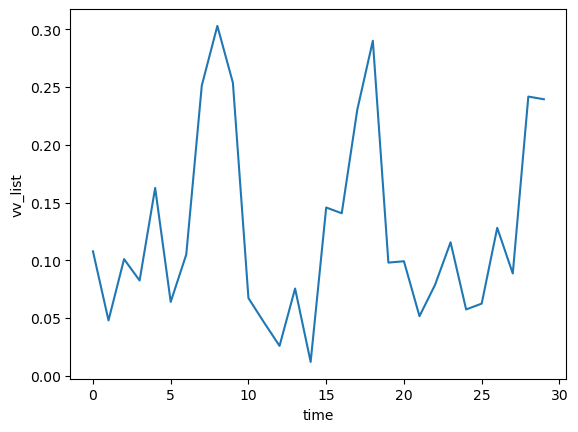

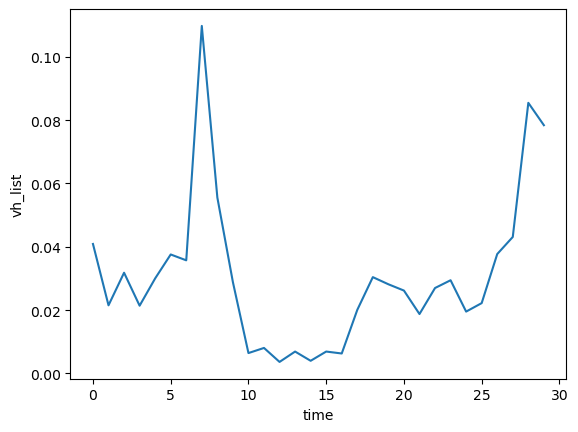

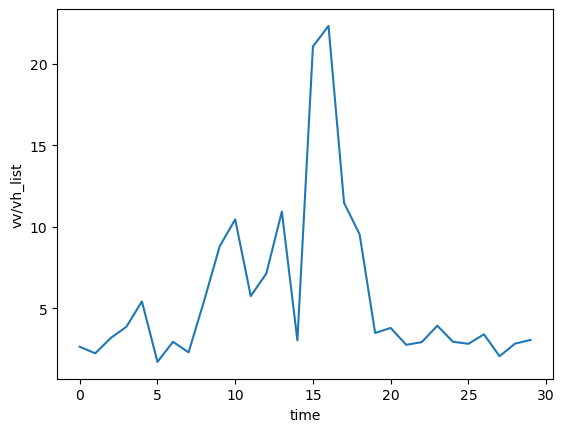

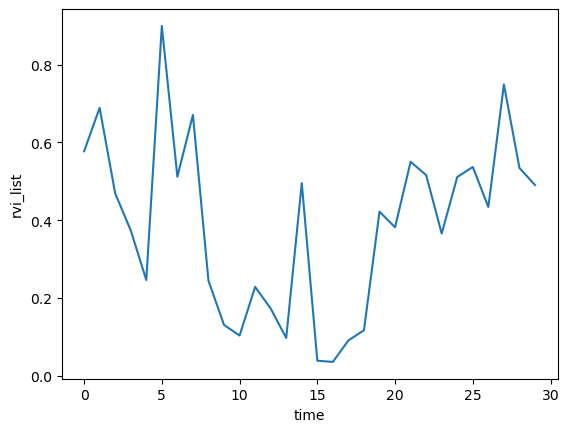

In [22]:
for i in range(550, 555):
    for j in range(4):
        plt.plot(pd.Series(data.iloc[i, j]))
        plt.xlabel("time")
        plt.ylabel(f'{data.columns[j]}')
        if data.columns[j] == 'vv/vh_list':
          plt.savefig(f'vv ratio vh for {i} entry season WS')
          plt.show()
          continue
        plt.savefig(f'{data.columns[j]}  for {i} entry season WS')
        plt.show()

## Divide the list of band values into 4 equal sized buckets

This is done so that the mean value in each bucket can be calculated. These mean values should be representative of the four major stages of rice growth: flooding, Transplanting, Tillering and maturity. RVI isn't included in this treatment.

In [23]:
def sub_list_1_mean(data):
    # data=eval(data)
    for i in data:
        if i==np.nan:
            del data[data.index(i)]
    index_1=len(data)//4
    index_2=2*index_1
    index_3=3*index_1
    index_4=len(data)
    return np.mean(data[0:index_1])
def sub_list_2_mean(data):
    # data=eval(data)
    for i in data:
        if i==np.nan:
            del data[data.index(i)]
    index_1=len(data)//4
    index_2=2*index_1
    index_3=3*index_1
    index_4=len(data)
    return np.mean(data[index_1:index_2])
def sub_list_3_mean(data):
    # data=eval(data)
    for i in data:
        if i==np.nan:
            del data[data.index(i)]
    index_1=len(data)//4
    index_2=2*index_1
    index_3=3*index_1
    index_4=len(data)
    return np.mean(data[index_2:index_3])
def sub_list_4_mean(data):
    # data=eval(data)
    for i in data:
        if i==np.nan:
            del data[data.index(i)]
    index_1=len(data)//4
    index_2=2*index_1
    index_3=3*index_1
    index_4=len(data)
    return np.mean(data[index_3:index_4])

In [24]:
for i in range (1, 5):
  if i == 1:
    data['sub_1_vv_mean']=data['vv_list'].apply(sub_list_1_mean)
    data['sub_1_vh_mean']=data['vh_list'].apply(sub_list_1_mean)
    data['sub_1_vv/vh_mean']=data['vv/vh_list'].apply(sub_list_1_mean)
  if i == 2:
    data['sub_2_vv_mean']=data['vv_list'].apply(sub_list_2_mean)
    data['sub_2_vh_mean']=data['vh_list'].apply(sub_list_2_mean)
    data['sub_2_vv/vh_mean']=data['vv/vh_list'].apply(sub_list_2_mean)
  if i == 3:
    data['sub_3_vv_mean']=data['vv_list'].apply(sub_list_3_mean)
    data['sub_3_vh_mean']=data['vh_list'].apply(sub_list_3_mean)
    data['sub_3_vv/vh_mean']=data['vv/vh_list'].apply(sub_list_3_mean)
  if i == 4:
    data['sub_4_vv_mean']=data['vv_list'].apply(sub_list_4_mean)
    data['sub_4_vh_mean']=data['vh_list'].apply(sub_list_4_mean)
    data['sub_4_vv/vh_mean']=data['vv/vh_list'].apply(sub_list_4_mean)


    

In [25]:
data.shape

(657, 16)

### Seed to make all processes deterministic 

This will ensure reproducibility of the notebook's results

In [26]:
import random

In [27]:
import os

In [28]:
# :seed to make all processes deterministic     
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [29]:
SEED = 42
seed_everything(SEED)

### Feature Engineering
Here, some important statistical fetures are engineered to better describe the time series
#### Creating some statistical features from the band values

Now let us generate few statistical features. Here we generate 6 features for VV, VH and VV/VH. The six statistical features are:
<ul>
    <li>Minimum</li>
    <li>Maximum</li>
    <li>Range</li>
    <li>Mean</li> 
    <li>Auto Correlation</li>
    <li>Permutation Entropy</li>
    <li>Skew</li>
    <li>Kurtosis</li>
</ul>

<p align="justify">
Auto Correlation - Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values.
</p>

<p align="justify">
Permutation Entropy - Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns.
</p>

<p align="justify">
Skew - Skew/skewness is a measure of the symmetry or assymetry of a data distribution
</p>

<p align="justify">
Kurtosis - Kurtosis measures whether the data is heaviy-tailed or light-tailed
</p>


In [30]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [31]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [32]:
import scipy

In [33]:
import statistics as stats

In [34]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [35]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv = min((row[0]))
        max_vv = max((row[0]))
        # median_vv=stats.median(row[0])
        range_vv = max_vv - min_vv
        mean_vv = np.mean((row[0]))
        correlation_vv = sm.tsa.acf((row[0]))[1]
        permutation_entropy_vv = permutation_entropy((row[0]), dx=6,base=2, normalized=True)
        skew_vv=skew((row[0]), axis=0, bias=True)
        kurtosis_vv=kurtosis((row[0]), axis=0, bias=True)
    
        min_vh = min((row[1]))
        max_vh = max((row[1]))
        # median_vh=stats.median(row[1])
        range_vh = max_vh - min_vh
        mean_vh = np.mean((row[1]))
        correlation_vh = sm.tsa.acf((row[1]))[1]
        permutation_entropy_vh = permutation_entropy((row[1]), dx=6, base=2, normalized=True)
        skew_vh=skew((row[1]), axis=0, bias=True)
        kurtosis_vh=kurtosis((row[1]), axis=0, bias=True)
    
        min_vv_by_vh = min((row[2]))
        max_vv_by_vh = max((row[2]))
        # # median_vv_by_vh=stats.median(row[2])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean((row[2]))
        correlation_vv_by_vh = sm.tsa.acf((row[2]))[1]
        permutation_entropy_vv_by_vh = permutation_entropy((row[2]), dx=6, base=2, normalized=True)
        skew_vv_by_vh=skew((row[2]), axis=0, bias=True)
        kurtosis_vv_by_vh=kurtosis((row[2]), axis=0, bias=True)
        
        min_rvi = min((row[3]))
        max_rvi = max((row[3]))
        # # median_rvi=stats.median(row[3])
        range_rvi = max_rvi - min_rvi
        mean_rvi = np.mean((row[3]))
        correlation_rvi = sm.tsa.acf((row[3]))[1]
        permutation_entropy_rvi = permutation_entropy((row[3]), dx=6,base=2, normalized=True)
        skew_rvi=skew((row[3]), axis=0, bias=True)
        kurtosis_rvi=kurtosis((row[3]), axis=0, bias=True)
      
        

        
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv,  permutation_entropy_vv, skew_vv, kurtosis_vv,
                          min_vh, max_vh, range_vh, mean_vh, correlation_vh,  permutation_entropy_vh, skew_vh, kurtosis_vh, 
                          min_vv_by_vh, max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh, skew_vv_by_vh, kurtosis_vv_by_vh,
                              min_rvi, max_rvi, range_rvi, mean_rvi, correlation_rvi, permutation_entropy_rvi, skew_rvi, kurtosis_rvi])
                              
    return features_list

In [36]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(data)
features_data = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv',' permutation_entropy_vv', 'skew_vv', 'kurtosis_vv',
                          'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh', 'skew_vh', 'kurtosis_vh',
                          'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh',' permutation_entropy_vv_by_vh', 'skew_vv_by_vh', 'kurtosis_vv_by_vh',
                                                 'min_rvi', 'max_rvi', 'range_rvi', 'mean_rvi', 'correlation_rvi', ' permutation_entropy_rvi', 'skew_rvi', 'kurtosis_rvi'])
                                                 

In [37]:
features_data.iloc[550:555, :]

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,skew_vv,kurtosis_vv,min_vh,max_vh,...,skew_vv_by_vh,kurtosis_vv_by_vh,min_rvi,max_rvi,range_rvi,mean_rvi,correlation_rvi,permutation_entropy_rvi,skew_rvi,kurtosis_rvi
550,0.008798,0.341299,0.332501,0.108319,0.084176,0.489247,0.974188,0.411606,0.003703,0.051097,...,2.323503,5.070385,0.020545,1.098374,1.077828,0.430306,-0.109827,0.480818,0.361676,-0.591920
551,0.006863,0.337995,0.331132,0.108794,0.218487,0.463962,1.136611,1.266851,0.002037,0.078712,...,2.821573,7.034394,0.023413,1.167132,1.143720,0.478373,0.153457,0.480818,0.498441,0.051838
552,0.009740,0.431196,0.421456,0.107541,0.313220,0.480818,1.658536,2.400892,0.002422,0.075311,...,3.135194,8.502303,0.021853,1.356852,1.334998,0.502373,0.114176,0.489247,0.928248,1.598799
553,0.018208,0.205360,0.187151,0.094000,0.120388,0.472390,0.679058,-0.682755,0.003401,0.064506,...,3.365933,11.258572,0.018040,1.447971,1.429932,0.482047,0.439566,0.480818,0.974332,1.449077
554,0.012104,0.302785,0.290682,0.125790,0.468433,0.489247,0.811485,-0.572242,0.003645,0.109759,...,2.051781,3.661472,0.035540,0.899300,0.863759,0.389311,0.449432,0.489247,0.100173,-0.745692


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_three_datasets</b></i> to combine the predictor variables and response variables.

In [38]:
def combine_three_datasets(dataset1,dataset2, dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    dataset3 - Dataset 3 to be combined
    '''
    data = pd.concat([dataset1,dataset2, dataset3], axis=1)
    return data

<p align="justify"> Now let us select the columns required for our model building exercise. Here we consider only the statistical features generated using the band values for training the model. Here we are not including latitude and longitude as predictor variables since they have no effect on the rice yield.</p>

In [39]:
# Prepare the original_data for concatenation. This data is essentially the combined train(crop_yield_data) and test data
original_data.reset_index(drop=True, inplace=True)

In [40]:
crop_data = combine_three_datasets(original_data, features_data, data)

drop_columns=['vv_list', 'vh_list', 'vv/vh_list', 'rvi_list', 'Latitude', 'Longitude', 'Season(SA = Summer Autumn, WS = Winter Spring)', 'Date of Harvest', 'District', 'Rice Crop Intensity(D=Double, T=Triple)']
# for i in crop_data.columns:
#     if ('min' in i) or ('max' in i):
#         drop_columns.append(i)
crop_data.drop(drop_columns, axis=1, inplace=True)
crop_data=convert_types(crop_data)
crop_data.head()


,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,skew_vv,kurtosis_vv,...,sub_1_vv/vh_mean,sub_2_vv_mean,sub_2_vh_mean,sub_2_vv/vh_mean,sub_3_vv_mean,sub_3_vh_mean,sub_3_vv/vh_mean,sub_4_vv_mean,sub_4_vh_mean,sub_4_vv/vh_mean
0,3.400391,5500,0.021790,0.332275,0.310303,0.109253,0.501953,0.389893,1.271484,1.424805,...,4.191406,0.093018,0.008240,15.234375,0.203857,0.030060,7.304688,0.051300,0.022903,2.248047
1,2.429688,6000,0.075867,0.357910,0.281982,0.186890,0.077515,0.389893,0.630371,0.003620,...,3.083984,0.176514,0.044342,4.203125,0.222778,0.048309,4.593750,0.136719,0.027542,4.839844
2,1.950195,6400,0.023590,0.410156,0.386475,0.116333,0.077454,0.389893,1.572266,1.523438,...,4.933594,0.205444,0.022964,13.289062,0.070312,0.027710,2.349609,0.047607,0.022293,2.294922
3,4.300781,6000,0.024994,0.353271,0.328125,0.110229,0.204102,0.389893,1.243164,0.636719,...,4.191406,0.187134,0.013161,15.593750,0.067810,0.026688,2.527344,0.066162,0.025620,2.490234
4,3.300781,6400,0.021439,0.218628,0.197144,0.103516,0.121033,0.389893,0.415771,-0.687500,...,6.265625,0.126709,0.029160,5.781250,0.105469,0.022415,4.511719,0.102112,0.034668,3.427734


Retreive the train and test data

In [41]:
crop_data_train=crop_data.loc[crop_data['Rice Yield (kg/ha)']!='test']

In [42]:
test_data=crop_data.loc[crop_data['Rice Yield (kg/ha)']=='test']

In [43]:
# save the predictor variables for test fields to a variable, 'test1'
test_1=test_data.drop(columns=['Rice Yield (kg/ha)'])

In [43]:
# save the predictor variables to a csv file
test_1.to_csv('test_fields.csv', index=False)

## Seperate Train and target

In [44]:
X = crop_data_train.drop(columns=['Rice Yield (kg/ha)'])
y = crop_yield_data ['Rice Yield (kg/ha)']

### Model Training and selection

Boosting models are better suited for smaller, structured/tabular data. They also outperform single regression models as they are ensembles of other models (decision trees in particular)

In [48]:
# Install Model
!pip install catboost
!pip install xgboost
!pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [49]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Model Training and Out-of-sample evaluation

With the stratifiedkfold split, the model is trained n_splits times. 
For each split, the model is trained on a given subset of train data. The model is then evaluated on the other hold-out subset of the train data. 
The resulting r2 scores for each fold is then averaged
The stratifiedkfold split preserves the distribution of the target in the hold-out set such that the model 'sees' a similar target distribution as in the original train data each time it is trained.

In [52]:
from sklearn.model_selection import StratifiedKFold
oof_r2=[]



fold=StratifiedKFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model = CatBoostRegressor()
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
    preds=model.predict(X_test)
    

    print(f'r2, fold {i}: {r2_score(y_test,preds)}')
    i+=1                
    oof_r2.append(r2_score(y_test,preds))

print(np.mean(oof_r2))

r2, fold 1: 0.69390088279417
r2, fold 2: 0.6115767346223331
r2, fold 3: 0.69024117876244
r2, fold 4: 0.6602742430552253
r2, fold 5: 0.5960153653714548
0.6504016809211246


In [51]:
from sklearn.model_selection import StratifiedKFold
oof_r2=[]



fold=StratifiedKFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    model = XGBRegressor()
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
    preds=model.predict(X_test)
    

    print(f'r2, fold {i}: {r2_score(y_test,preds)}')
    i+=1                
    oof_r2.append(r2_score(y_test,preds))

print(np.mean(oof_r2))

r2, fold 1: 0.59278598793271
r2, fold 2: 0.5989263130755577
r2, fold 3: 0.6297315542776878
r2, fold 4: 0.6085596481690014
r2, fold 5: 0.5543517002043084
0.596871040731853


In [50]:
from sklearn.model_selection import StratifiedKFold
oof_r2=[]



fold=StratifiedKFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    


    model = LGBMRegressor()
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
    preds=model.predict(X_test)
    

    print(f'r2, fold {i}: {r2_score(y_test,preds)}')
    i+=1                
    oof_r2.append(r2_score(y_test,preds))

print(np.mean(oof_r2))

r2, fold 1: 0.6074085089015866
r2, fold 2: 0.565280887547342
r2, fold 3: 0.6456224545279405
r2, fold 4: 0.6000138018655813
r2, fold 5: 0.5294165926699071
0.5895484491024715


### Catboost does better than the other models across all folds. Hence, it is the right candidate for hyperparameter tuning

## Hyperparameter tuning

In [53]:
pip install optuna

  Using cached optuna-3.1.1-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


In [55]:
import optuna

In [113]:
X = X


def objective(trial):
    fold_pred=[]
    oof_pred = []


    param = {}

    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)

    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)

    param['max_depth'] = trial.suggest_int("max_depth", 5, 10)
  
    param['n_estimators'] = trial.suggest_int('n_estimators', 400,1200)




    fold=StratifiedKFold(n_splits=5)
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        m2 = CatBoostRegressor(**param)


        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200, verbose=False)#erly100
        preds=m2.predict(X_test)
        oof_pred.append(r2_score(y_test,preds))

    return np.mean(oof_pred)

In [114]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2023-04-18 23:27:30,723] A new study created in memory with name: no-name-acbf0261-9f4a-4765-8fea-4759d3c64feb
[I 2023-04-18 23:27:52,139] Trial 0 finished with value: 0.611285709422083 and parameters: {'learning_rate': 0.2318148130501033, 'subsample': 0.23638623693596147, 'max_depth': 9, 'n_estimators': 832}. Best is trial 0 with value: 0.611285709422083.
[I 2023-04-18 23:28:06,374] Trial 1 finished with value: 0.6499563013102192 and parameters: {'learning_rate': 0.012387185855149878, 'subsample': 0.9021874856524369, 'max_depth': 7, 'n_estimators': 707}. Best is trial 1 with value: 0.6499563013102192.
[I 2023-04-18 23:28:32,443] Trial 2 finished with value: 0.6431815324418626 and parameters: {'learning_rate': 0.011345459978165568, 'subsample': 0.873238545107187, 'max_depth': 8, 'n_estimators': 544}. Best is trial 1 with value: 0.6499563013102192.
[I 2023-04-18 23:28:50,568] Trial 3 finished with value: 0.6445416866437867 and parameters: {'learning_rate': 0.03178379356107174, 'subsa

In [ ]:
#get best hyper parameters
study.best_params

## Final Model fit

In [59]:
params={'learning_rate': 0.057535630537942965, 'subsample': 0.6714528862033073, 'max_depth': 5, 'n_estimators': 871}
model = CatBoostRegressor(**params, verbose=False)

In [60]:
model.fit(X, y)

## Save model as pkl

In [61]:
import pickle
pickle.dump(model, open('final_model.pkl', 'wb'))

### Feature importance

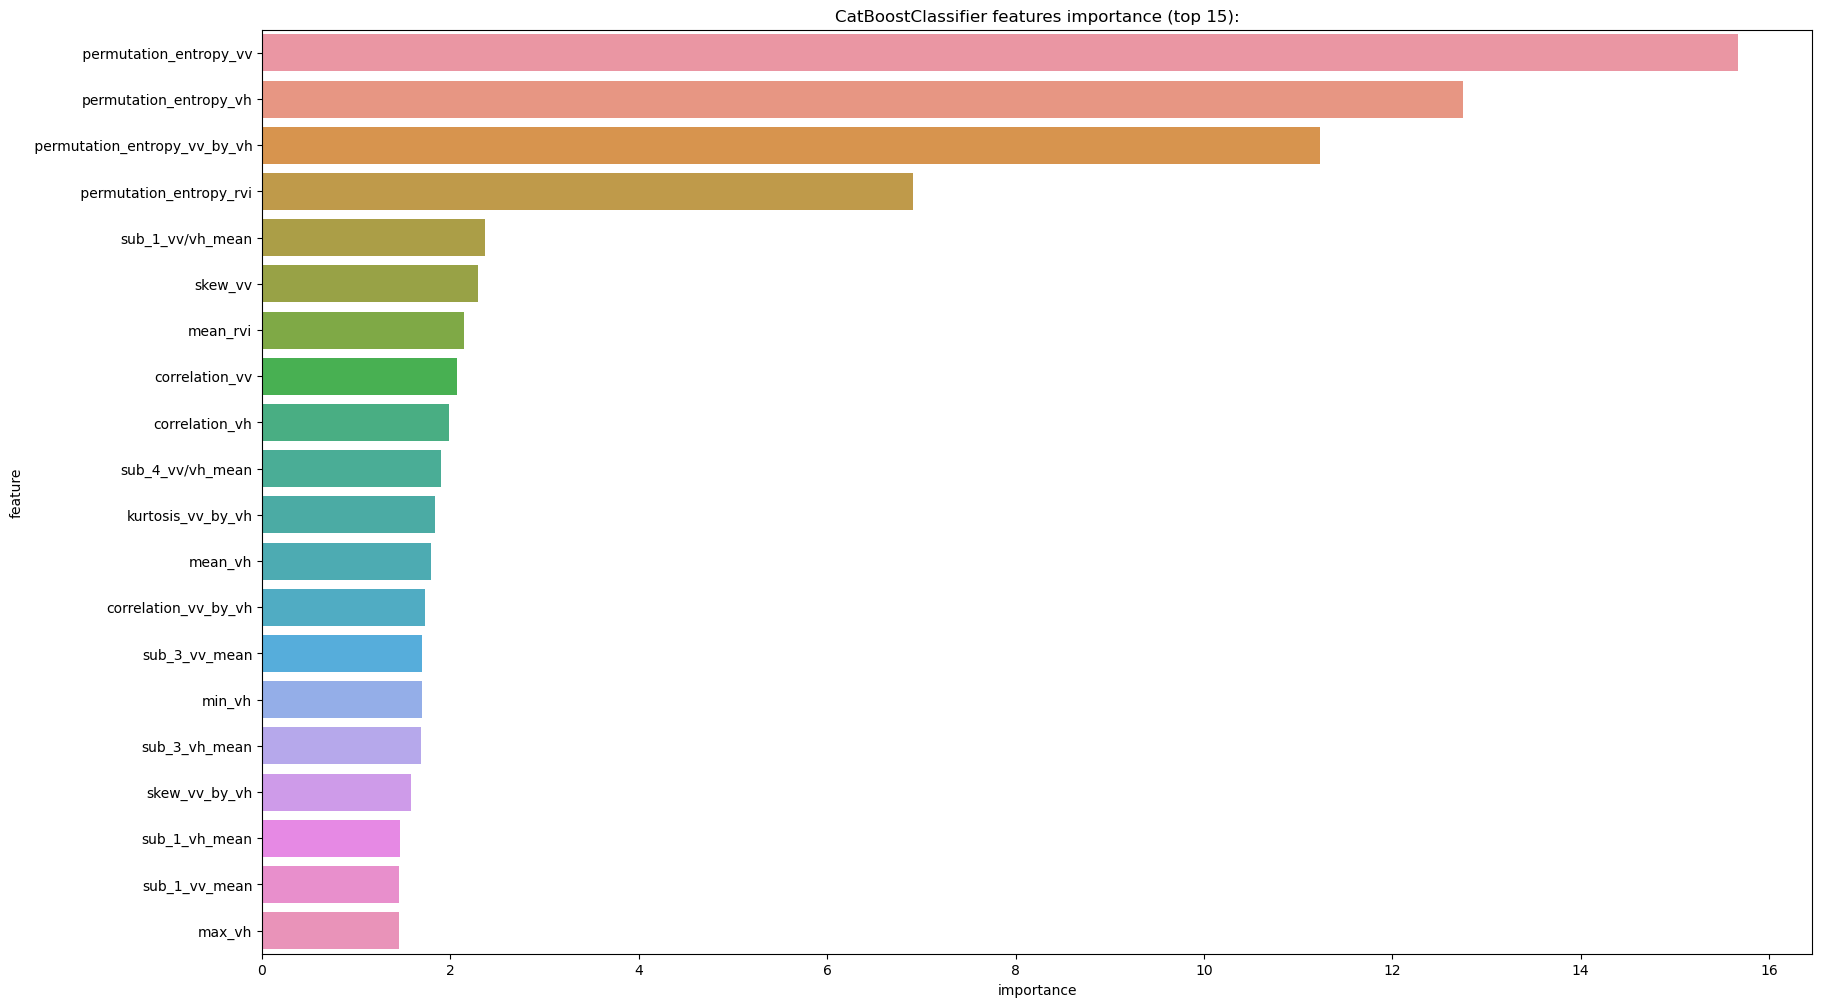

In [62]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('CatBoostClassifier features importance (top 15):');
plt.savefig('feature importance plot.png')

## Error analysis for predictions on the train set

In [63]:
t=np.arange(500)
y1=pd.Series(model.predict(X))
y2=y
y3=y1-y2


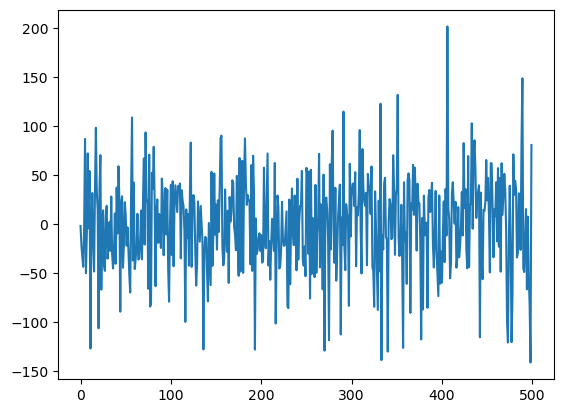

In [64]:
import matplotlib.pyplot as plt
plt.plot(t, y3[:500])
plt.savefig('error analysis.png')
plt.show()

The difference between the predicted and the true yield values follows a random distribution